Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5085629.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 130167.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1270579.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4482477.36it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



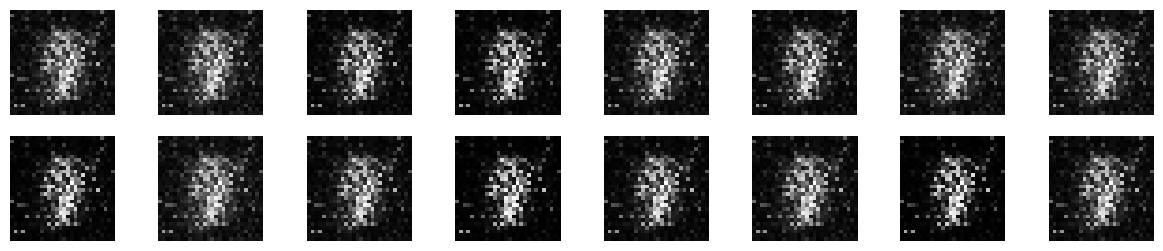

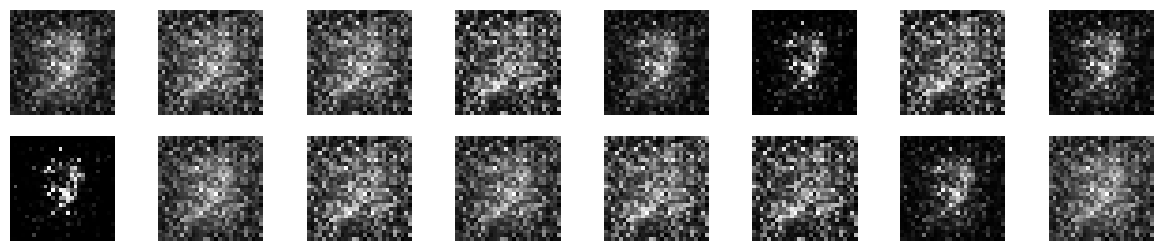

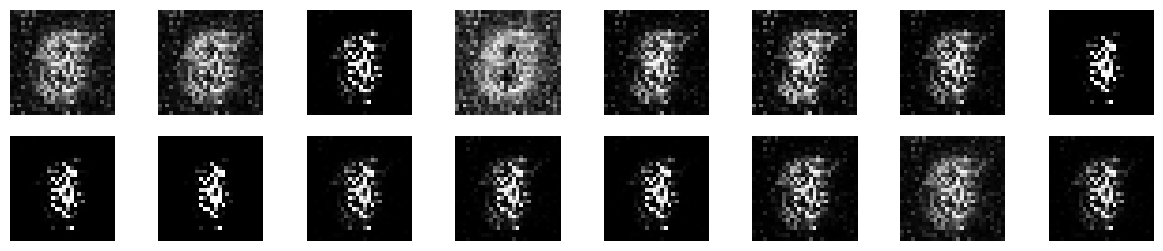

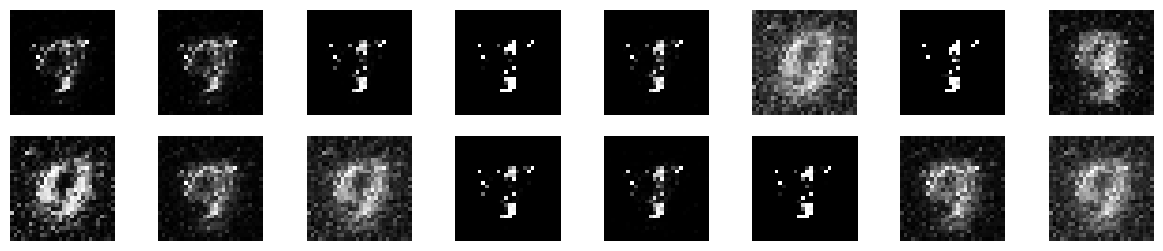

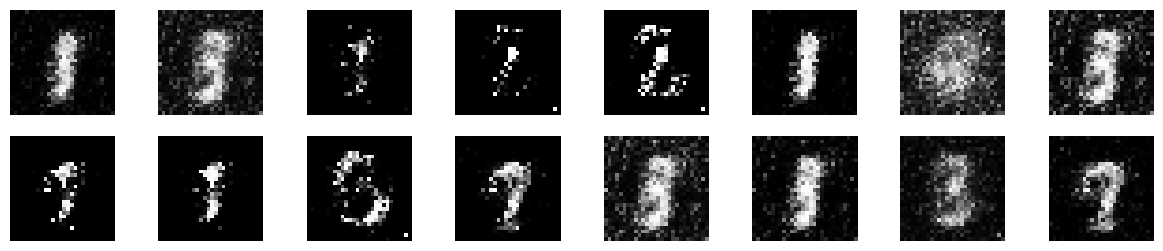

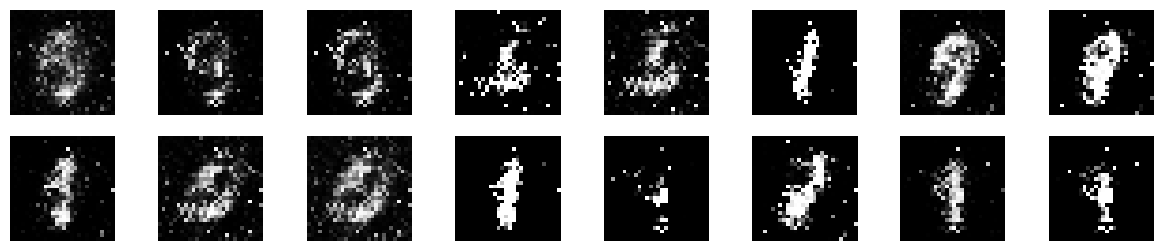

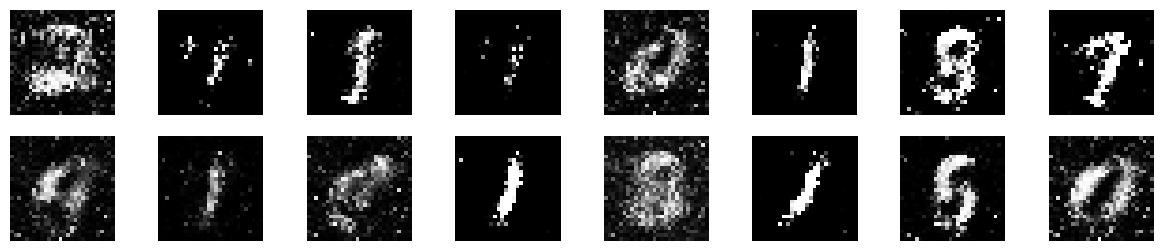

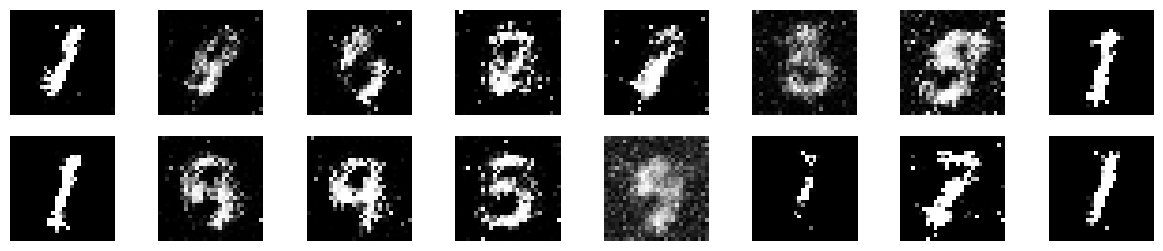

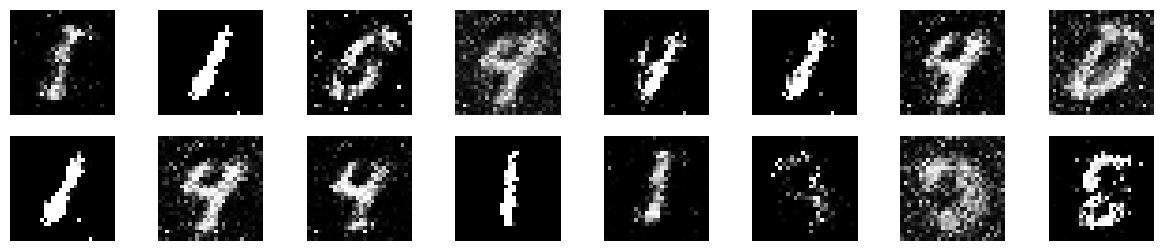

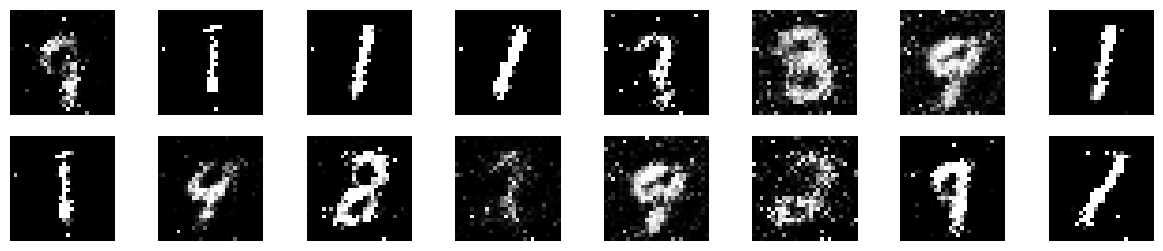

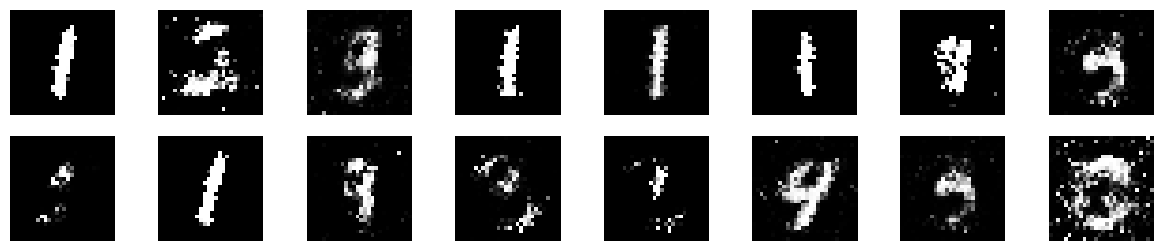

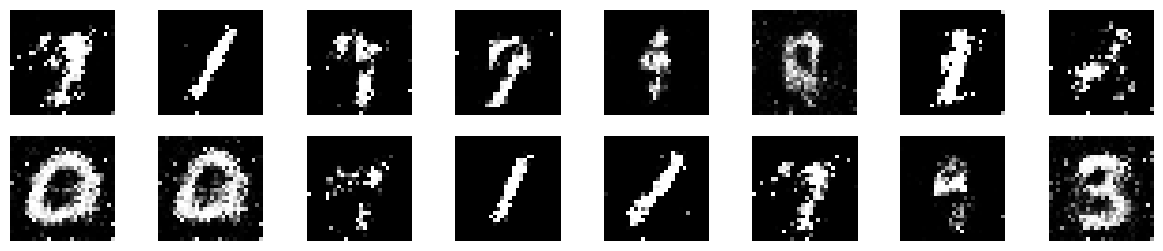

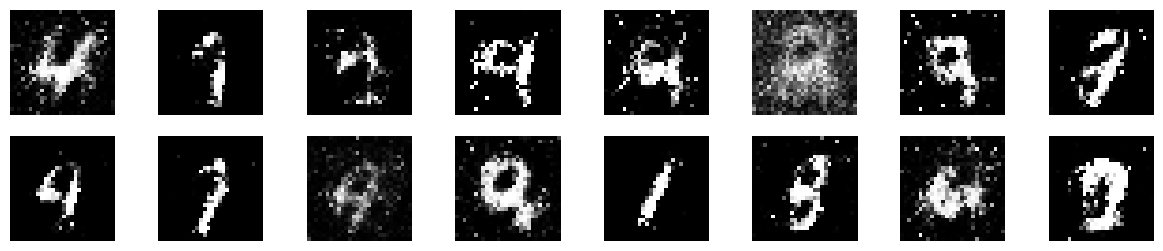

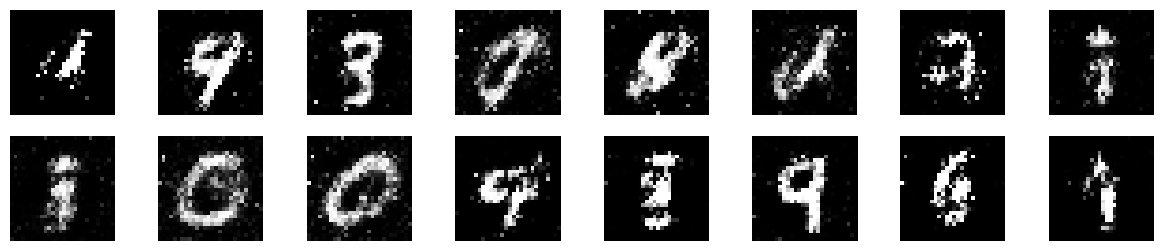

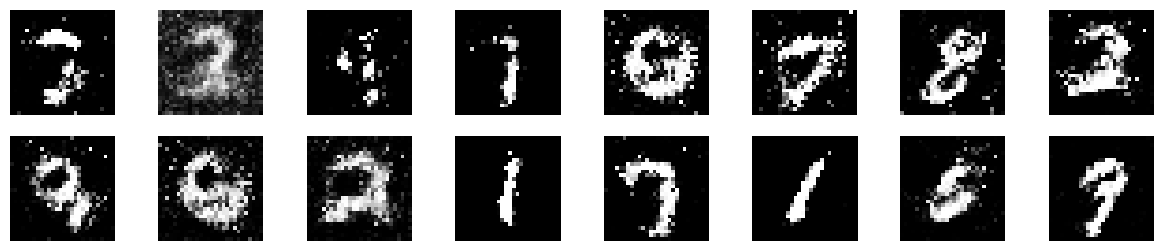

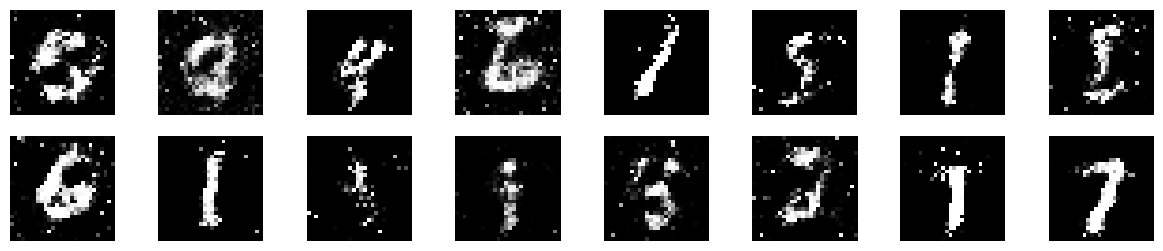

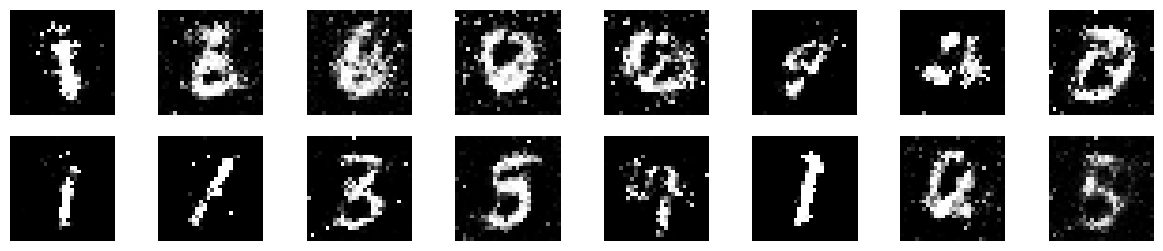

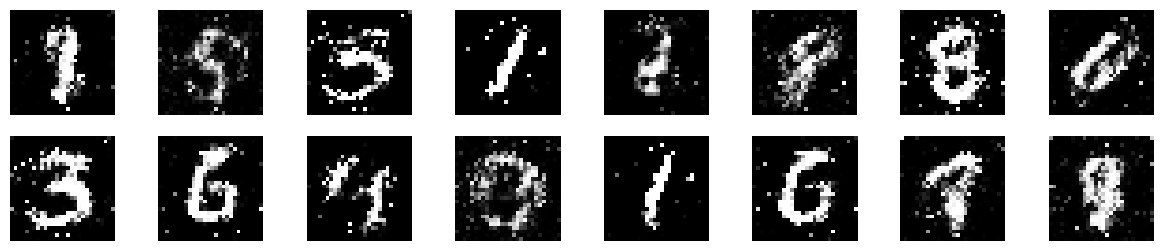

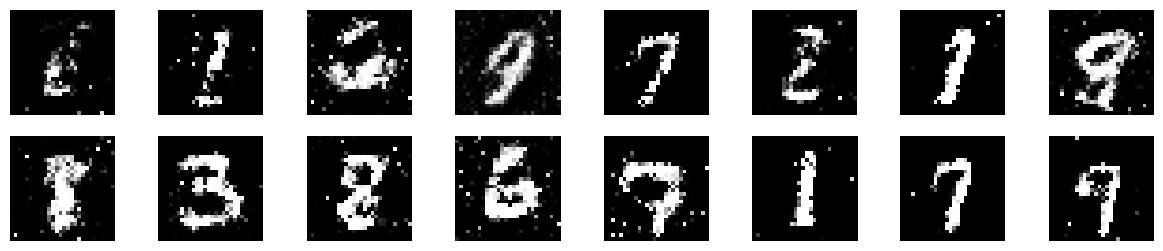

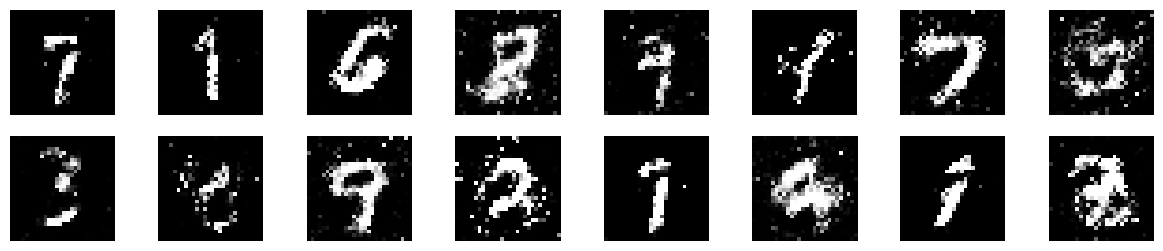

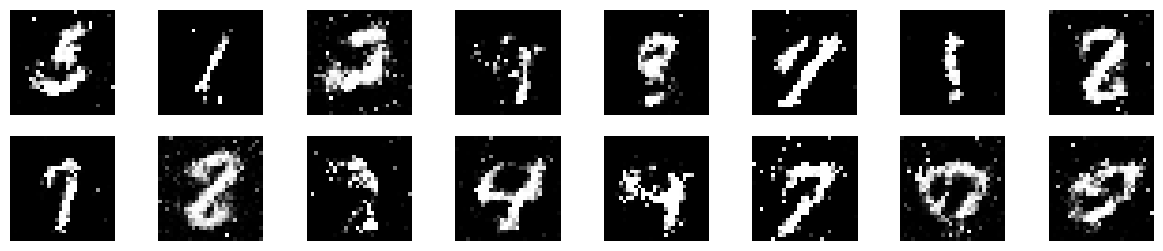

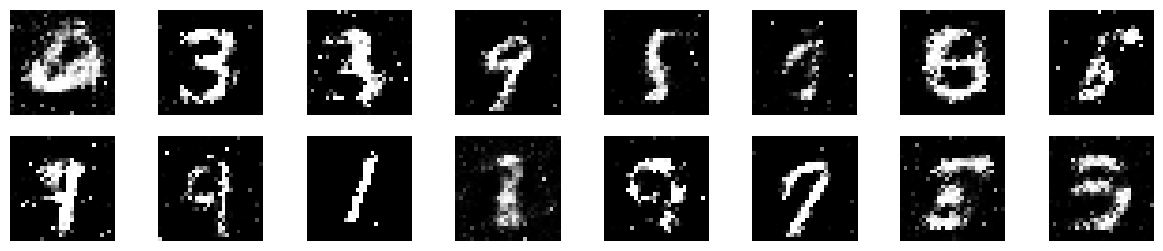

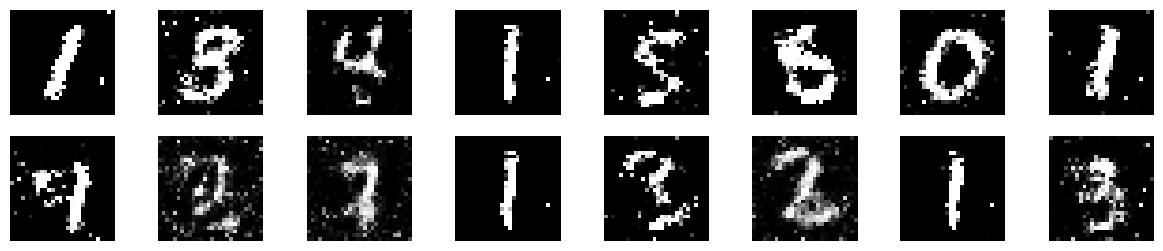

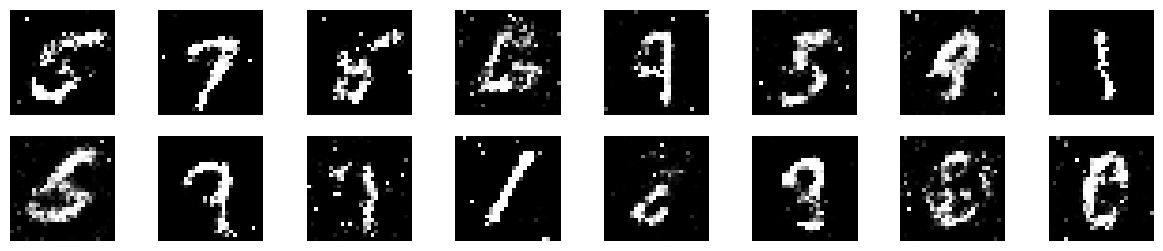

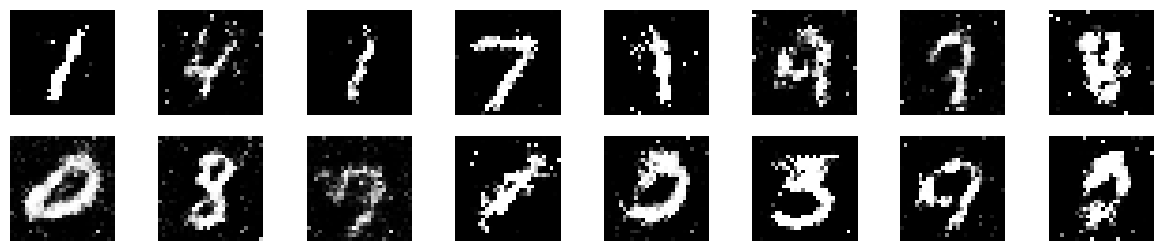

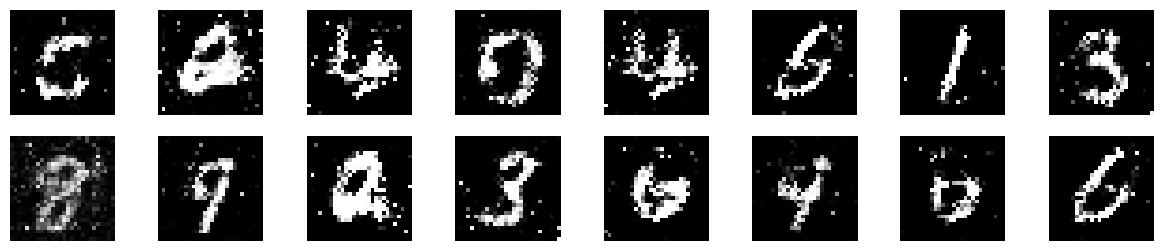

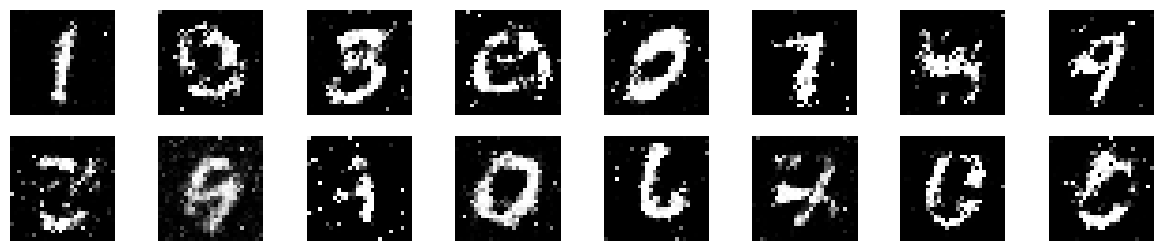

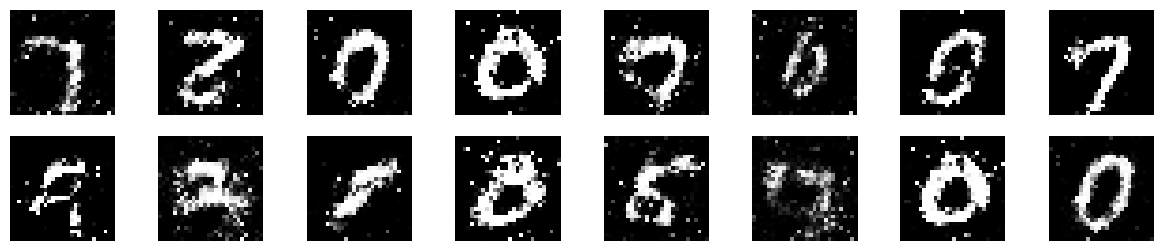

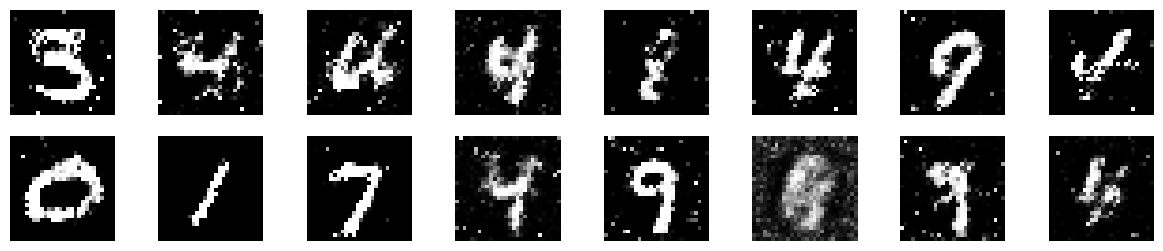

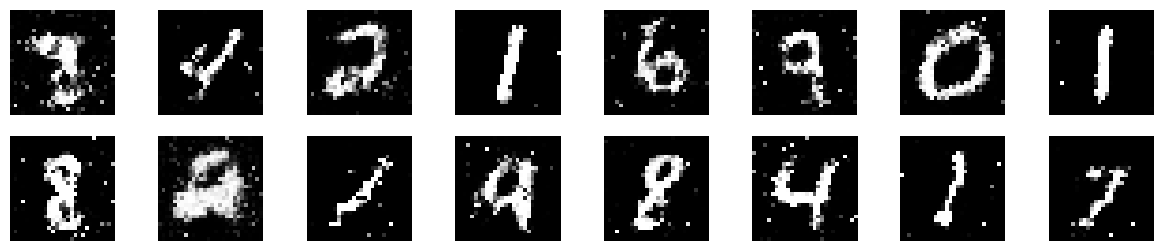

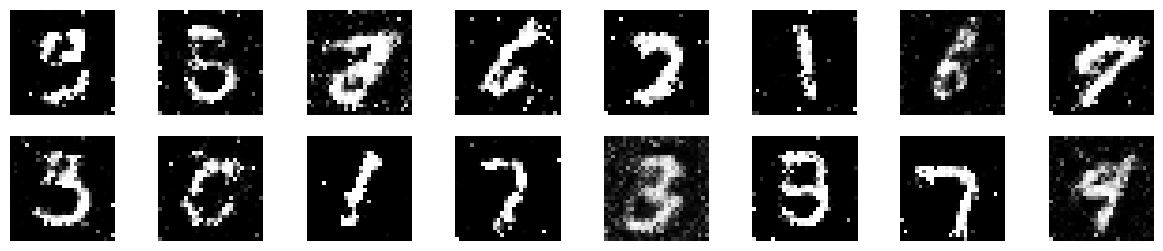

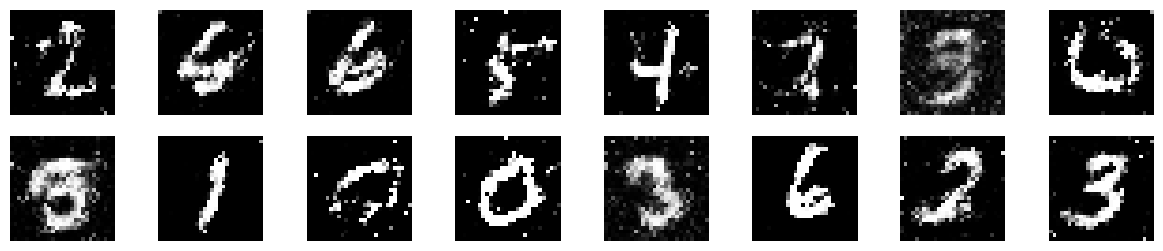

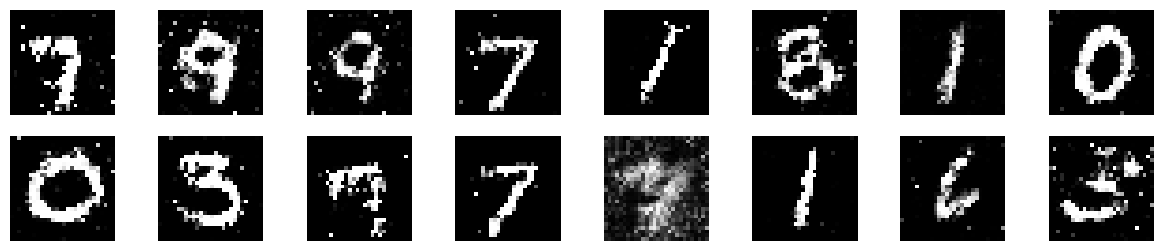

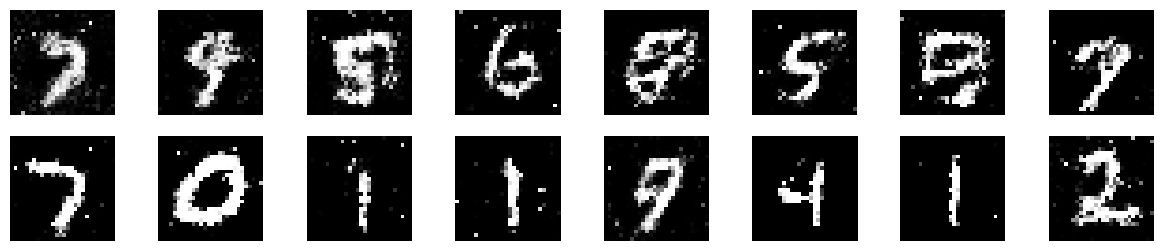

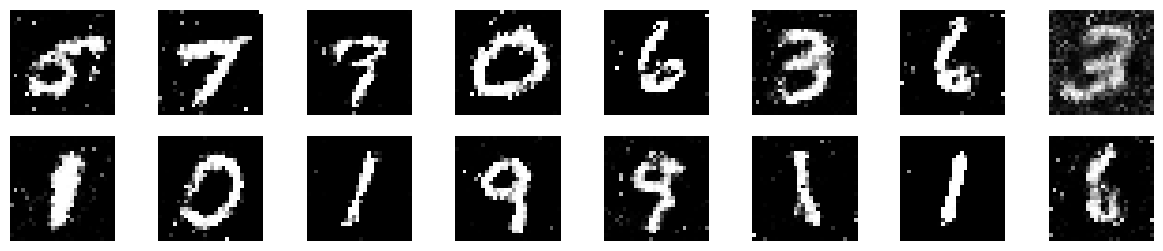

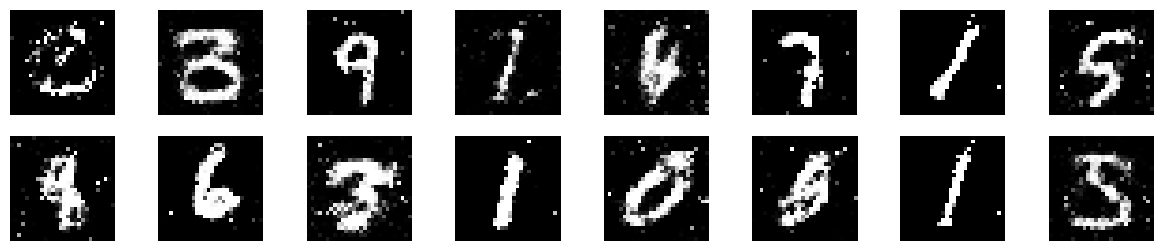

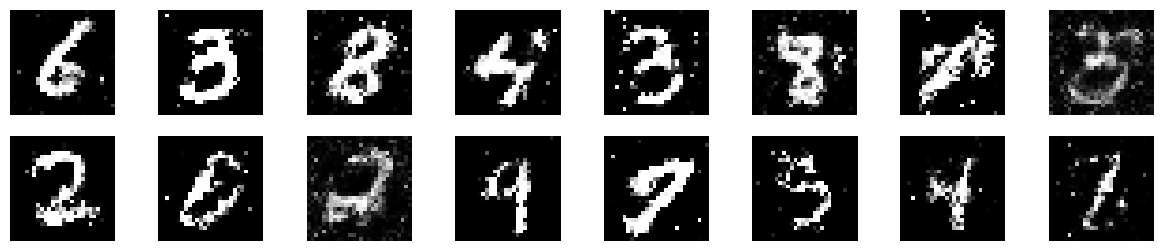

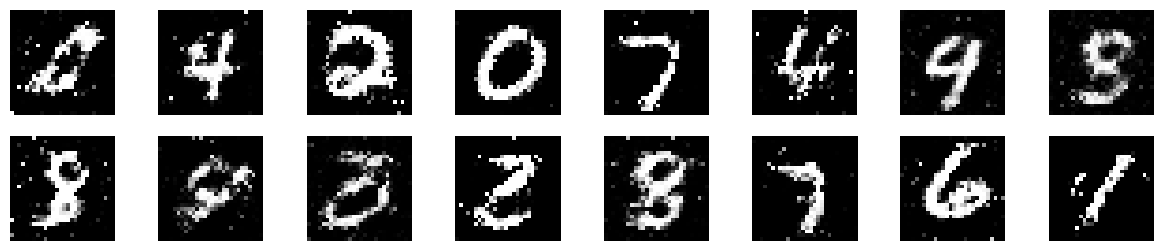

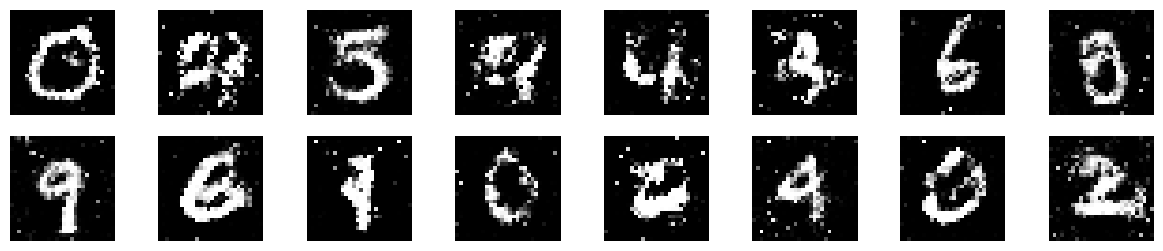

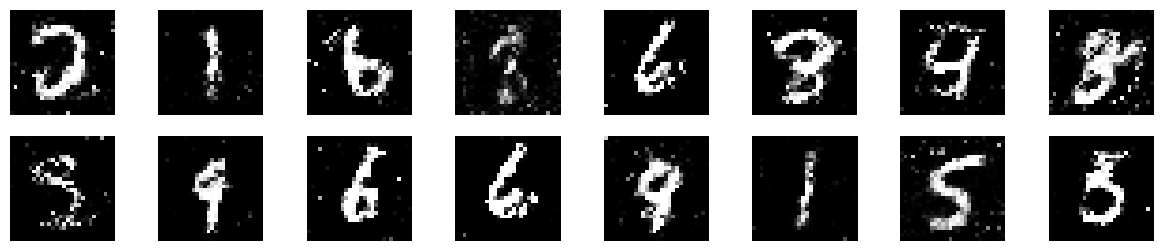

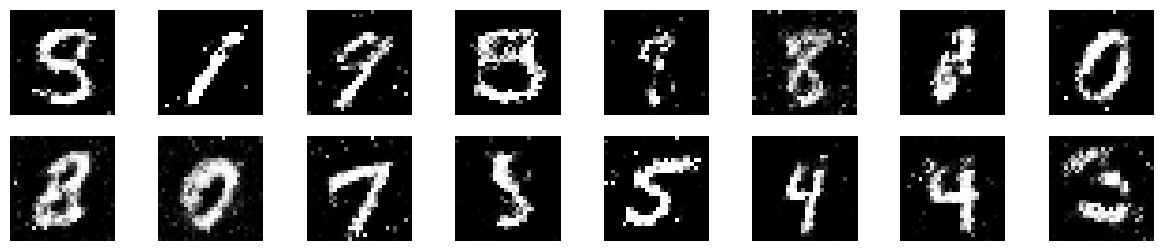

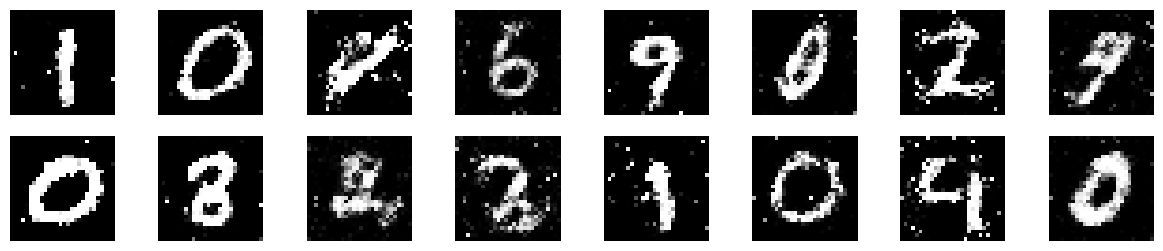

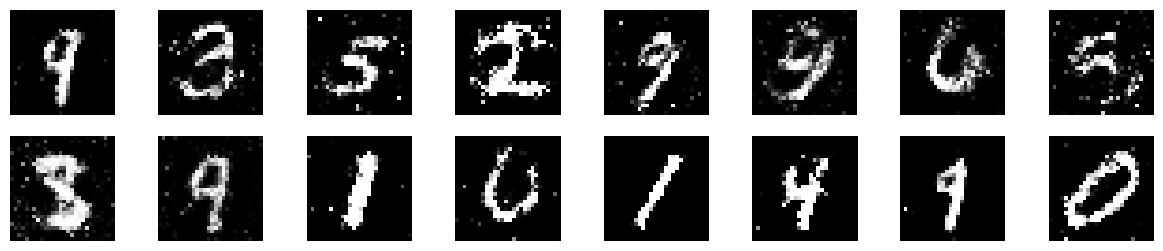

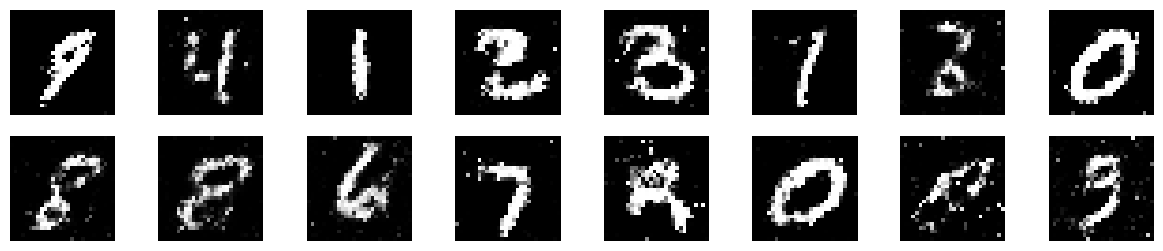

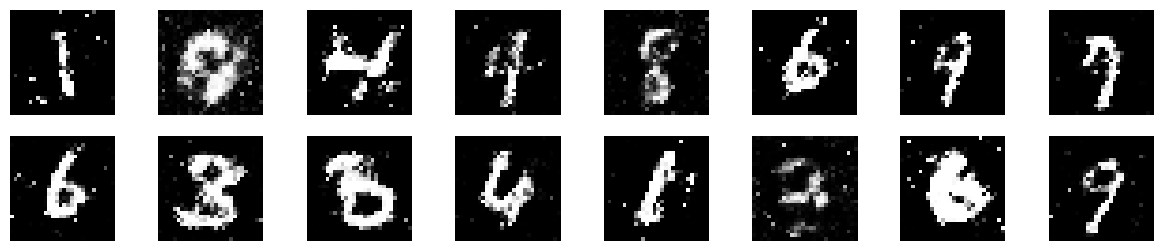

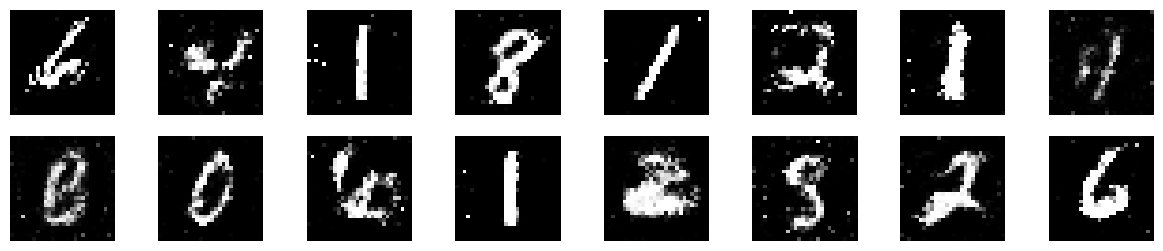

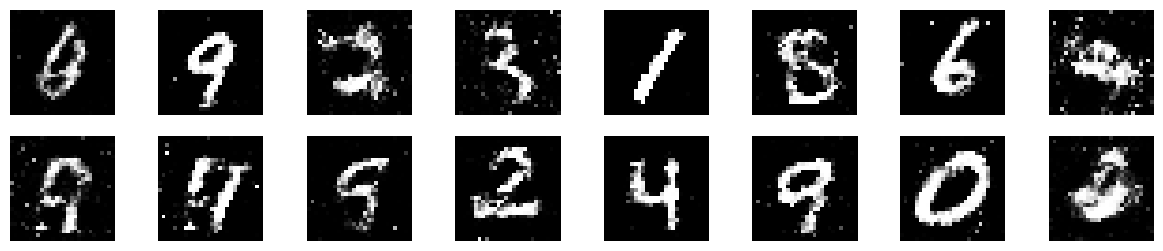

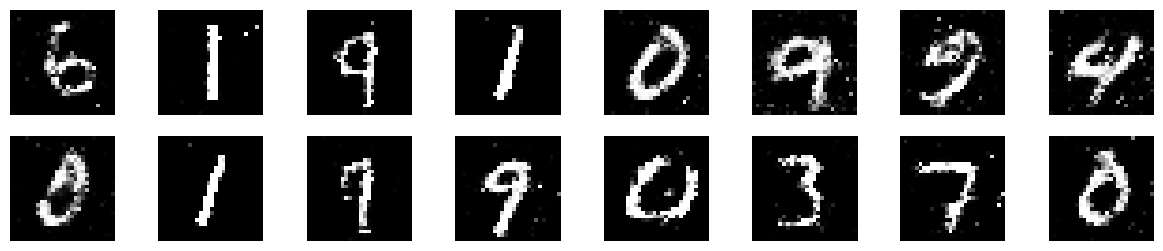

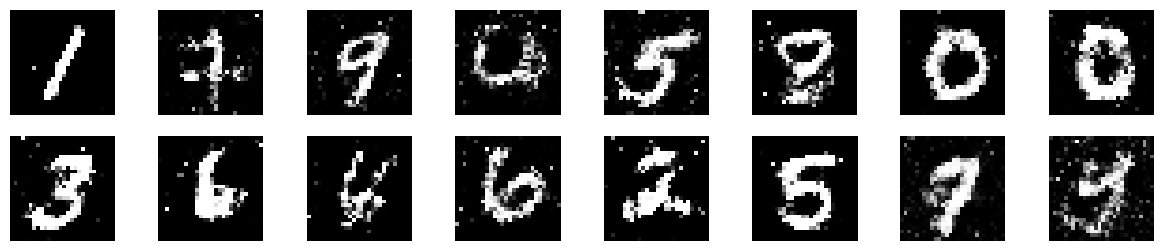

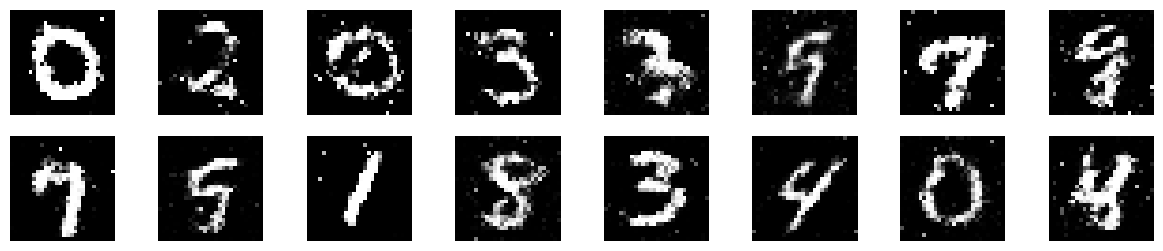

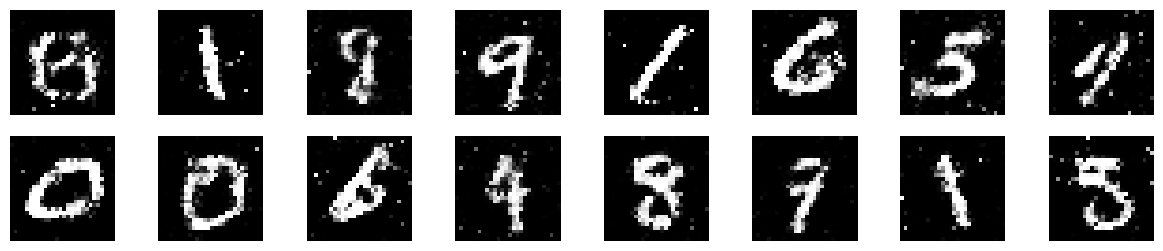

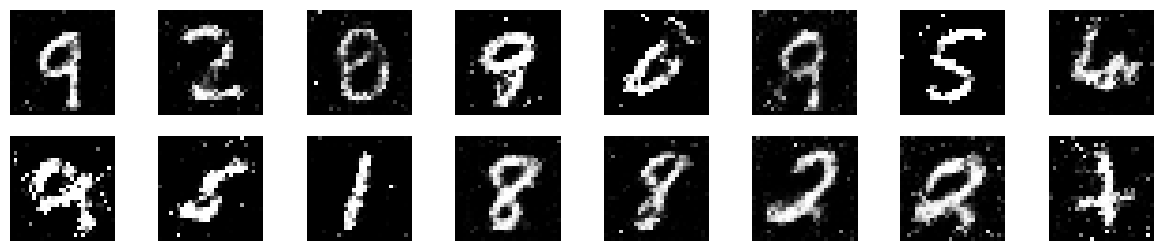

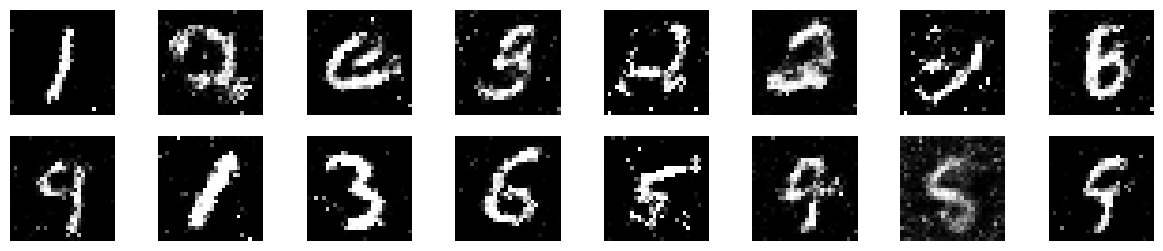

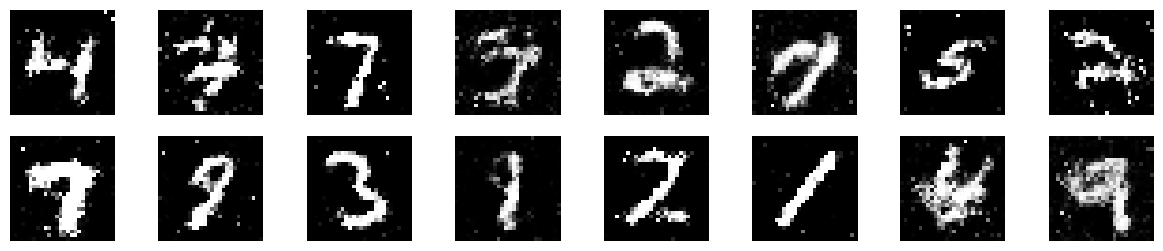

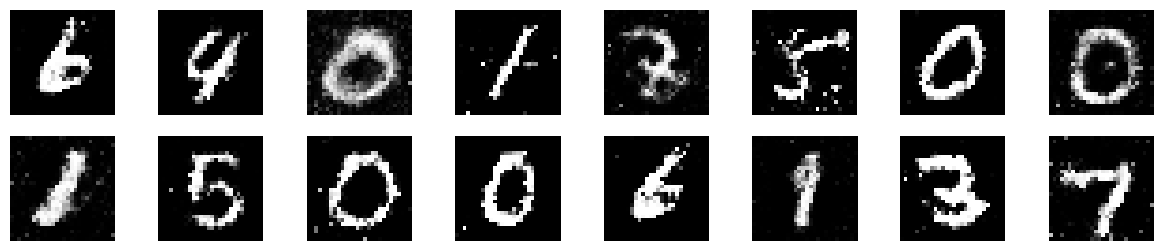

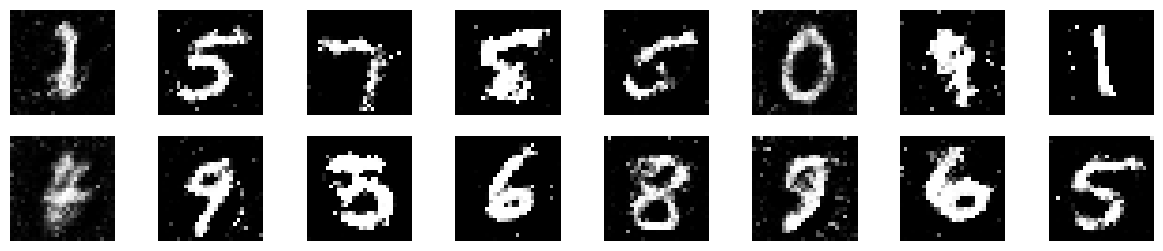

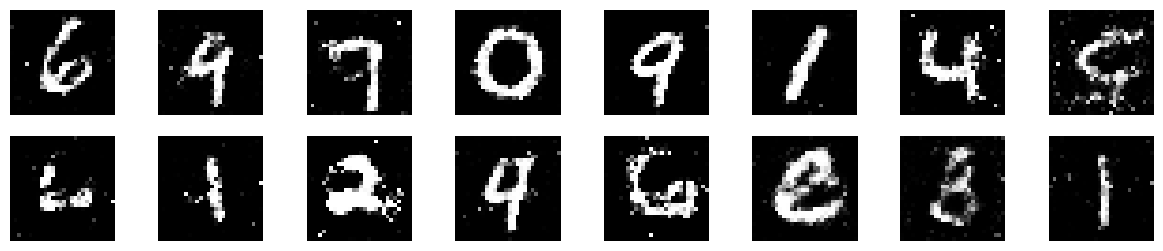

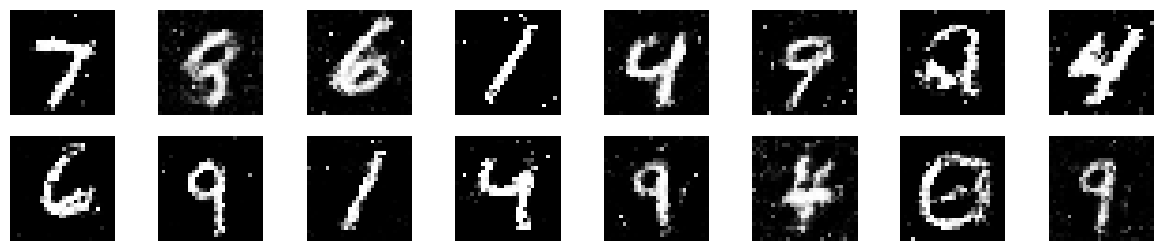

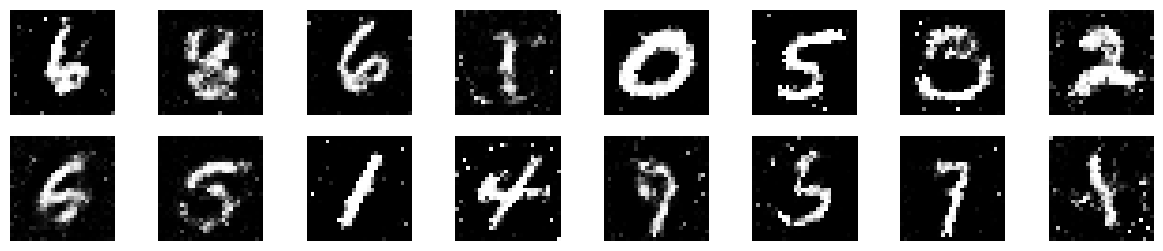

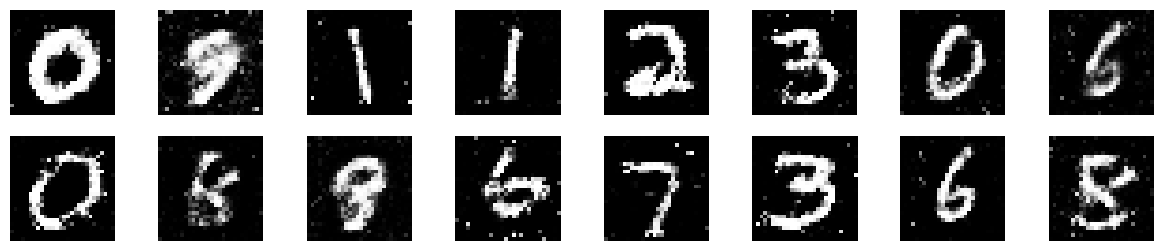

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Verificar la disponibilidad de la GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Crear un directorio para almacenar las imágenes generadas
os.makedirs('gan_images', exist_ok=True)

# Configuración de parámetros
latent_dim = 100
image_size = 28 * 28
batch_size = 64

# Definir la arquitectura del generador
generator = nn.Sequential( # Parte de una imagen de tamaño 10x10(=100) cuyos pixels contienen datos al azar
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784), # Y genera una imagen de tamaño 28x28(784) cuyos pixxels deben tener valoresd qwue se asemejen a los de las fotos de nuestra librería MNIST
            nn.Tanh()
).to(device)

# Definir la arquitectura del discriminador
discriminator = nn.Sequential(
            nn.Linear(784, 1024), # Partimos de una iogamen de 28x28 (generada por el generador o una imagen real del mnist)
            nn.ReLU(),
            nn.Dropout(0.3), # Esto hace que en las distintas iteraciones, se supriman aletaoriamente un 30% de las neuronas... Evita que haya neuronas que se usen demasiado... haciendo que otras neoronas no aprendan
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1), # Acabamos con un dato -> Si la imagen es buena o no
            nn.Sigmoid()
).to(device)

# Cargar y preprocesar los datos MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=True)

# Inicializar los optimizadores. Esta es la función que trata de identificar el mínimo en la función de error (pérdida)
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002)

# Función de pérdida. Esta función mira básicamente en cuantas se ha equivocado el discriminador al discriminar entre las imágenes reales y las autogeneradas
criterion = nn.BCELoss()

# Entrenamiento de la GAN
num_epochs = 60
for epoch in range(num_epochs):
    for real_images, _ in data_loader: # Aquí es donde se aplcia el batch_size (leemos las imágenes de 64 en 64)
        # Insuflar al discrimiador imágenes REALES
        real_images = real_images.view(-1, image_size).to(device) # Saco un paquete de imágenes y las coloco en el dispositivo (RAM asociada a la CPU, o en la RAM de la GPU)
        real_labels = torch.ones(real_images.size(0), 1).to(device) # Generado datos (Y) para esas imágenes. 1 significa que la imagen es REAL (sacada del mnist)
        optimizer_discriminator.zero_grad() # Resetear el optimizador para comenzar a calcular los valores que minimizan la función de pérdida
        outputs = discriminator(real_images) # Discrima las imágenes reales: Generamos la estimación del DISCRIMINADOR (en el caso ideal, un discriminador perfecto, para todas debería devolver 1)
        loss_real = criterion(outputs, real_labels) # Calculan la función de pérdida para estos datos... Es decir... en cuantas se ha equivocado el discriminador
        loss_real.backward()  # Recálculo de los párametros

        # Insuflamos al discriminador imágenes que provienen del generador

        ## Generar imágenes por el GENERADOR, partiendo de RUIDO !
        noise = torch.randn(real_images.size(0), latent_dim).to(device) # Tantas imágenes como se hayan procesado reales (64)... de tamaño 100 pixels... llenas de ruido (números aleatorios)
        fake_images = generator(noise) # Y se las pasamos al generador... para que genere imágenes de tamaño 28x28, parecidas a las del mnist... o no!
        fake_labels = torch.zeros(real_images.size(0), 1).to(device) # Generado datos (Y) para esas imágenes. 0 significa que la imagen es NO REAL (no está sacada del mnist)

        outputs = discriminator(fake_images.detach()) # Le pongo al disciminador a discriminar entre las que ha generado el GENERADOR ( si fuera un discriminador perfecto, todas darían 0)
        loss_fake = criterion(outputs, fake_labels) # Cálculo la función de pérdidas... Es decir, miro en cuántas se ha equivocado el discriminador
        loss_fake.backward() # Que aplicamos para hacer un recálculo de los parámetros

        optimizer_discriminator.step() # De ahora en adelante, hacemos que el discriminador trabaje con esos nuevos parámetros

        # Vamos a mejorar el generador ( ya con el discriminador mejorado)
        optimizer_generator.zero_grad()  # Lo inicializo
        outputs = discriminator(fake_images)  # Discrima los datos fake
        loss_generator = criterion(outputs, real_labels) # Y tendré nuevas equivocaciones (alguna menos)
        loss_generator.backward() # Y con esas pérdidas, recalculo los parámetros del generador

        optimizer_generator.step()  # Y le aplico esos parámetros para la siguiente tanda de imágenes.

    # Generar unas cuantas imágenes, para ver con nuestros ojitos que tal se comporta el generador!
    with torch.no_grad():
        target_digit = 7
        noise = torch.randn(16, latent_dim).to(device) # Genera 16 imágenes de 10x10 con ruido
        #noise[:, target_digit] = 2.0
        generated_images = generator(noise).cpu().detach() # Y se las pasamos al generador

    # Imprimirlas por pantalla... a ver cómo le fue
    fig, axes = plt.subplots(2, 8, figsize=(15, 3))
    for i in range(2):
        for j in range(8):
            axes[i, j].imshow(generated_images[i * 8 + j].view(28, 28), cmap='gray')
            axes[i, j].axis('off')
    plt.savefig(f'gan_images/epoch_{epoch + 1}_digit_{target_digit}.png')
    plt.show()
    plt.close()
